<a href="https://colab.research.google.com/github/YashDeepp/svmand-bert-for-disaster-classification/blob/main/Disaster_tweet_classifiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D,Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
tweet=pd.read_csv("https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv")

In [ ]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
tweet.shape

(7613, 5)

#EDA

In [ ]:


plt.rcParams['figure.figsize']=[8,4]
plt.rcParams['figure.dpi']=80


Text(0.5, 1.0, 'True or False Disaster Tweet')

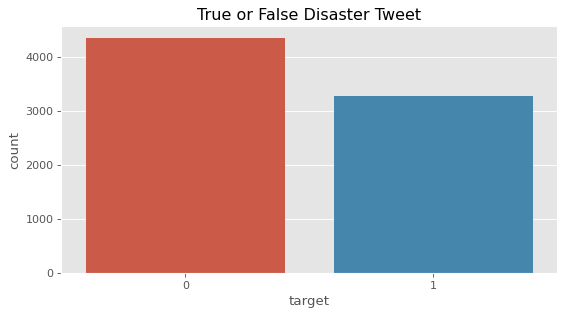

In [ ]:
sns.countplot(data=tweet,x='target')
plt.title('True or False Disaster Tweet')

In [ ]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<Axes: ylabel='target'>

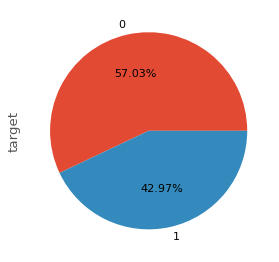

In [ ]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

In [ ]:
#Number of Characters

!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-qh0w3uot
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-qh0w3uot
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7620 sha256=6bb22eef8271cc745962f75675f0532ddc2d71d162386d3733918d53059c526d
  Stored in directory: /tmp/pip-ephem-wheel-cache-iyy3j3xz/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie


In [ ]:
import preprocess_kgptalkie as kgp

In [ ]:
tweet = kgp.get_basic_features(tweet)

<ipython-input-13-2229ae5f4b87>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet["char_counts"])


<Axes: xlabel='char_counts', ylabel='Density'>

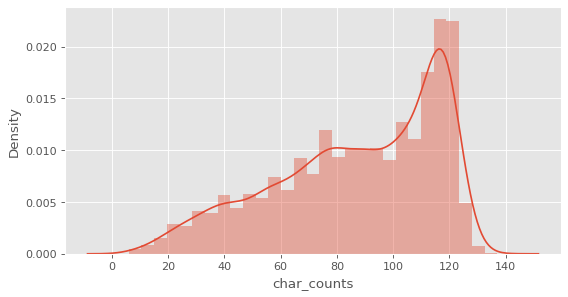

In [ ]:
 sns.distplot(tweet["char_counts"])

<ipython-input-14-3e2dac9119f2>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet['char_counts'],shade=True)


<Axes: xlabel='char_counts', ylabel='Density'>

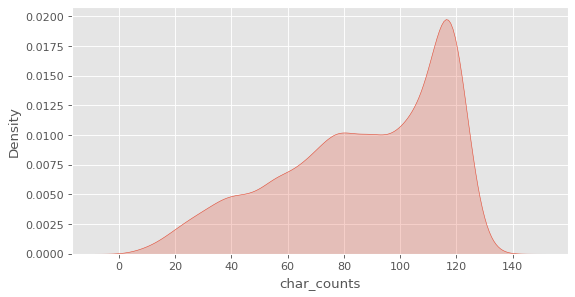

In [ ]:
sns.kdeplot(tweet['char_counts'],shade=True)

<Axes: xlabel='char_counts', ylabel='Density'>

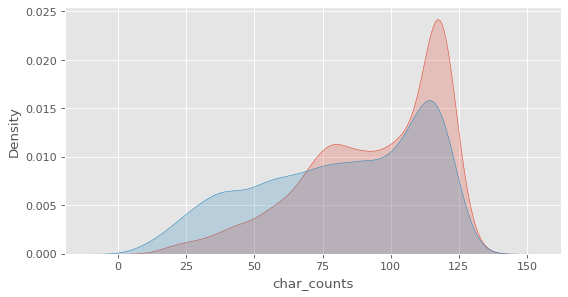

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'],fill=True)
sns.kdeplot(tweet[tweet['target']==0]['char_counts'],fill=True)

In [ ]:
freq=kgp.get_word_freqs(tweet, 'text')

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ').replace('.',' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x


In [ ]:
tweet['text']=tweet['text'].apply(lambda x: get_clean(x))

In [ ]:
#Visualization
real=kgp.get_word_freqs(tweet[tweet['target']==1],'text')
real= ' '.join(real.index)

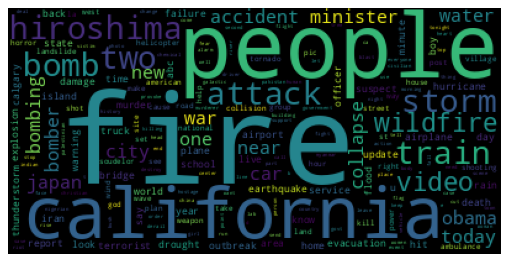

In [ ]:
word_cloud=WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

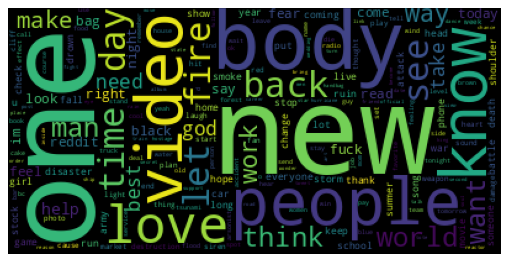

In [ ]:
fake=kgp.get_word_freqs(tweet[tweet['target']==0],'text')
fake= ' '.join(fake.index)
word_cloud=WordCloud(max_font_size=100).generate(fake)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
text=tweet['text']
y=tweet['target']


#SVM Model


###TFID

In [ ]:
tfidf=TfidfVectorizer()
x=tfidf.fit_transform(text)

In [ ]:
x.shape

(7613, 22546)

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(x , y , test_size=0.2, random_state=0, stratify=y)

In [ ]:
def run_SVM(clf,x_train,y_train,x_test,y_test):
  clf.fit(x_train,y_train)
  y_pred=clf.predict(x_test)

  print()
  print("Classification Report")
  print(classification_report(y_test,y_pred))

In [ ]:
from sklearn.svm import LinearSVC
clf=LinearSVC()

In [ ]:
%%time
run_SVM(clf,x_train,y_train,x_test,y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523

CPU times: user 59.6 ms, sys: 0 ns, total: 59.6 ms
Wall time: 77.7 ms


In [ ]:
import spacy
!python -m spacy download en_core_web_lg

2023-06-29 16:57:52.974774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


###Word2Vec

In [ ]:
import en_core_web_lg

In [ ]:
nlp=en_core_web_lg.load()

In [ ]:
def get_vec(x):
  doc=nlp(x)
  vec=doc.vector
  return vec

In [ ]:
tweet['vec']=tweet['text'].apply(lambda x: get_vec(x))

In [ ]:
x=tweet['vec'].to_numpy()
x=x.reshape(-1,1)

In [ ]:
x=np.concatenate(np.concatenate(x,axis=0),axis=0).reshape(-1,300)

In [ ]:
x.shape
y=tweet['target']

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(x , y , test_size=0.2, random_state=0, stratify=y)

In [ ]:
%%time
clf=LinearSVC()
run_SVM(clf,x_train,y_train,x_test,y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       869
           1       0.73      0.78      0.75       654

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.78      0.78      1523

CPU times: user 6.87 s, sys: 23.4 ms, total: 6.89 s
Wall time: 7.47 s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


###Word Embedding

In [ ]:

from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten

In [ ]:
token=Tokenizer()
token.fit_on_texts(text)

In [ ]:
vocab_size=len(token.word_index)+1
vocab_size

22582

In [ ]:
encoded_text=token.texts_to_sequences(text)

In [ ]:
max_length=40
x=pad_sequences(encoded_text , maxlen=max_length, padding='post')

In [ ]:
print(x)

[[ 109 4491   22 ...    0    0    0]
 [ 186   43  223 ...    0    0    0]
 [  41 1682 1435 ...    0    0    0]
 ...
 [2709 2295 4483 ...    0    0    0]
 [  75 1092   39 ...    0    0    0]
 [   2  206   55 ...    0    0    0]]


In [ ]:
x.shape

(7613, 40)

#Simple DNN Architecture


In [ ]:
vec_size=100
model=Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32,2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))

model.add(GlobalMaxPooling1D())

model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 100)           2258200   
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 32)            6432      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 32)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 19, 32)            0         
                                                                 
 dense_1 (Dense)             (None, 19, 32)            1056      
                                                                 
 dropout_2 (Dropout)         (None, 19, 32)            0         
                                                      

In [ ]:
%%time
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, validation_data=(x_test,y_test))

Epoch 1/5
191/191 [==============================] - 31s 105ms/step - loss: 0.6566 - accuracy: 0.6136 - val_loss: 0.6078 - val_accuracy: 0.7190
Epoch 2/5
191/191 [==============================] - 4s 23ms/step - loss: 0.4540 - accuracy: 0.8048 - val_loss: 0.4791 - val_accuracy: 0.7997
Epoch 3/5
191/191 [==============================] - 3s 15ms/step - loss: 0.2717 - accuracy: 0.8926 - val_loss: 0.4716 - val_accuracy: 0.7800
Epoch 4/5
191/191 [==============================] - 3s 15ms/step - loss: 0.1361 - accuracy: 0.9512 - val_loss: 0.5049 - val_accuracy: 0.7630
Epoch 5/5
191/191 [==============================] - 2s 12ms/step - loss: 0.0816 - accuracy: 0.9716 - val_loss: 0.5681 - val_accuracy: 0.7321
CPU times: user 29.5 s, sys: 1.55 s, total: 31.1 s
Wall time: 1min 23s


In [ ]:
def get_encoded(x):
  x=get_clean(x)
  x=token.texts_to_sequences([x])
  x=pad_sequences(x,maxlen=max_length, padding='post')
  return x

In [ ]:
t='i am in a flood'
vec=get_encoded(t)

In [ ]:
np.argmax(model.predict(vec), axis=-1)

1/1 [==============================] - 0s 18ms/step


array([0])

#BERT Model


In [ ]:
!pip install ktrain

In [ ]:
from ktrain import text
import ktrain

In [ ]:
(x_train,y_train),(x_test,y_test),preproc=text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

['not_target', 'target']
      not_target  target
5933         1.0     0.0
5978         1.0     0.0
1624         0.0     1.0
930          1.0     0.0
7320         0.0     1.0
['not_target', 'target']
      not_target  target
7461         0.0     1.0
240          1.0     0.0
2372         1.0     0.0
5985         1.0     0.0
7159         1.0     0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model=text.text_classifier(name='bert',
                           train_data=(x_train,y_train),
                           preproc=preproc)

Is Multi-Label? False
maxlen is 40


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [ ]:
learner= ktrain.get_learner(model=model, train_data=(x_train,y_train),val_data=(x_test,y_test),batch_size=64)

In [ ]:
learner.fit_onecycle(lr=2e-4,epochs=3)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 88s 590ms/step - loss: 0.5174 - accuracy: 0.7389 - val_loss: 0.3754 - val_accuracy: 0.8412


In [ ]:
predictor=ktrain.get_predictor(learner.model,preproc)
data=['I her today by accident',
      'i got into a car accident today and i am injured']
predictor.oredict(data,return_proba=True)